# Machine Learning for Complete Intersection Calabi-Yau Manifolds

We use machine learning (ML) techniques to predict the Hodge numbers of Calabi-Yau 3-folds. The relevant numbers are $h_{11}$ and $h_{21}$. We use several approaches. Specifically:

1. evaluate different algorithms using Scikit-learn (for each one of them build a baseline with only the configuration matrix for both $h_{11}$ and $h_{21}$, then use feature engineering to improve the results):
    
    - [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html),
    
    - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html),
    
    - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html),
    
    - [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html),
    
    - [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html),
    
    - [SVR (rbf)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html),
    
    - [Gradient Boosted Tree](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html),
    
    - [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
    
2. build a working **Convolutional Neural Network** (CNN) using [Tensorflow-Keras](https://www.tensorflow.org/api_docs/python/tf/keras):

    - build a baseline with a **sequential** model,
    
    - use the **functional** API to improve the net,
    
3. build a fully connected **Deep Neural Network** using only dense layers (DNN) using the same framework in order to have another usable model with a completely different architecture,
    
4. use **stacking** to improve the overall result (keep in mind that no matter how bad an algorithm can be, its stacked version can significantly improve, provided that the stacked algorithms are sufficiently diverse amongst them).

## Setup and Typical Functions

Before moving to the actual computations, we build a usable framework for the notebook. We import some modules and write a few functions which we will use from now on.

In [6]:
import sys
import json
import tarfile
import warnings
import numpy              as np
import matplotlib         as mpl
import matplotlib.pyplot  as plt
import sklearn            as sk
import tensorflow         as tf
import pandas             as pd

from os                          import path, mkdir, environ
from urllib                      import request as rq
from IPython.display             import Image
from scipy.stats                 import uniform
from joblib                      import load, dump
from tensorflow                  import keras
from sklearn.base                import BaseEstimator, TransformerMixin
from sklearn.preprocessing       import StandardScaler
from sklearn.model_selection     import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from skopt                       import BayesSearchCV
from skopt.space                 import Categorical, Real, Integer
from sklearn.metrics             import mean_squared_error, make_scorer
from sklearn.decomposition       import PCA
from sklearn.cluster             import KMeans
from sklearn.linear_model        import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.svm                 import LinearSVR, SVR
from sklearn.ensemble            import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from tensorflow                  import keras
from tensorflow.keras            import backend as K
from tensorflow.keras.models     import Model, Sequential, save_model, load_model
from tensorflow.keras.layers     import Input, Dense, Conv2D, concatenate, Dropout, MaxPool2D, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks  import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils      import plot_model

assert sys.version_info >= (3, 6)     # require at least Python 3.6
assert np.__version__   >  '1.16'     # to avoid issues with pytables
assert sk.__version__   >= '0.22.1'   # for the recent implementation
assert tf.__version__   >= '2.0.0'    # newest version
assert tf.test.is_built_with_cuda()   # to use GPU in the computations

warnings.simplefilter(action='ignore', category=UserWarning) # do not print every single warning I can't do anything about...
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'                        # do not print Tensorflow warnings

gpus = tf.config.experimental.list_physical_devices('GPU')   # set memory growth to avoid taking the entire GPU RAM
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('\nGPU setup:')
        print('  ',len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)
else:
    print('\nNo GPUs in the setup!')


GPU setup:
   1 Physical GPUs, 1 Logical GPUs


Now create the working environment (directories, plotting functions, etc.) in order to have callable methods throughout the notebook:

In [7]:
#########################################
# WORKING DIRECTORIES                   #
#########################################

ROOT_DIR = '.'      # root directory
IMG_DIR  = 'img'    # images directory
LOG_DIR  = 'log'    # logs directory
MOD_DIR  = 'models' # models directory

# Create and/or define the directories
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
if path.isdir(IMG_PATH) is False:
    mkdir(IMG_PATH)

LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
if path.isdir(LOG_PATH) is False:
    mkdir(LOG_PATH)

MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
if path.isdir(MOD_PATH) is False:
    mkdir(MOD_PATH)

SEED = np.random.seed()
RAND = np.random.randint(0,1000)

#########################################
# MATPLOTLIB DEFINITIONS                #
#########################################

# Set label sizes
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Save the current figure
def save_fig(name, tight_layout=True, extension='png', resolution=600):

    filename = path.join(IMG_PATH, name + '.' + extension)
    if tight_layout:
        plt.tight_layout()

    print('\nSaving {}...'.format(filename))
    plt.savefig(filename, format=extension, dpi=resolution)
    print('Saved {}!'.format(filename))

# Get a generator to count the occurrencies
def get_counts(df, label, feature):

    for n in np.sort(df[feature].unique()):
        uniques, counts = np.unique(df[label].loc[df[feature] == n].values, \
                                    return_counts=True)
        for u, c in np.c_[uniques, counts]:
            yield [ n, u, c ]

# Plot histogram of occurrencies
def count_plot(ax, data, title=None, xlabel=None, ylabel='N',
               legend=None, xlog=False, ylog=False, binstep=5,
               **kwargs):

    min_tick = np.min(data) if np.min(data) > -100 else -100 # set a MIN cut in the plot
    max_tick = np.max(data) if np.max(data) < 100  else 100  # set a MAX cut in the plot

    ax.grid(alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(min_tick, max_tick, step=binstep))

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    # create a histogram using a step function
    ax.hist(data, histtype='step', label=legend, **kwargs)

    if legend is not None:
        ax.legend(loc='best')

    return ax

# Plot labeled features and their values
def label_plot(ax, data, title=None, xlabel=None, ylabel='values',
               legend=None, xlog=False, ylog=False, binstep=1,
               **kwargs):
    
    ax.grid(alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len([f[0] for f in data]), step=binstep))
    ax.set_xticklabels([f[0] for f in data], ha='right', rotation=45)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    ax.plot(np.arange(len([f[0] for f in data])), [f[1] for f in data],
            label=legend, **kwargs)

    if legend is not None:
        ax.legend(loc='best')

    return ax

# Plot the correlation matrix of a Pandas dataframe
def mat_plot(ax, df, label='correlation matrix', **kwargs):

    matrix = df.corr()
    labels = df.columns.tolist()

    ax.set_xticks(np.arange(len(labels), step=1))
    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticks(np.arange(len(labels), step=1))
    ax.set_yticklabels([''] + labels)
                    
    matshow = ax.matshow(matrix, vmin=-1.0, vmax=1.0, **kwargs)
                                
    cbar = ax.figure.colorbar(matshow, ax=ax, fraction=0.05, pad=0.05)
    cbar.ax.set_ylabel(label, va='bottom', rotation=-90)

    return ax

# Plot a scatter plot with colours and sizes
def scatter_plot(ax, data, title=None, xlabel=None, ylabel=None,
                 legend=None, xlog=False, ylog=False,
                 colour=True, size=True, colour_label='N', size_leg=0,
                 **kwargs):

    ax.grid(alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if xlog:
        ax.set_xscale('log')

    if ylog:
        ax.set_yscale('log')

    if colour:
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], c=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], c=data[2], **kwargs)
        cbar = ax.figure.colorbar(scat, ax=ax)
        cbar.ax.set_ylabel(colour_label, rotation=-90, va='bottom')
    else:
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], **kwargs)

    scat.set_label(legend)
    if size_leg:
        handles, labels = scat.legend_elements('sizes', num=size_leg)
        ax.legend(handles, labels, loc='lower center',
                  bbox_to_anchor=(0.5,-0.3), ncol=len(handles),
                  fontsize='medium', frameon=False)

    if legend:
        ax.legend(loc='best')

    return ax

# Plot a series with trivial x label
def series_plot(ax, data, title=None, xlabel='series', ylabel=None,
                legend=None, xlog=False, ylog=False,
                step=False, std=False, scale_fac=1, **kwargs):

    ax.grid(alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')

    series = np.arange(len(data))
    data   = [ x * scale_fac for x in data ]

    if step:
        ax.step(series, data, label=legend, **kwargs)
    else:
        ax.plot(series, data, label=legend, **kwargs)

    if std:
        ax.fill_between(series, data + np.std(data), data - np.std(data), alpha=0.2)

    if legend is not None:
        ax.legend(loc='best')

Then build scoring and evaluation functions using Numpy library methods. The idea is to have callable methods taking `(y_true, y_pred)` as inputs and returning the absolute error and the accuracy (with or without rounding):

In [8]:
#########################################
# NUMPY DEFINITIONS                     #
#########################################

# Get the accuracy (possibly after rounding)
def accuracy_score(y_true, y_pred, rounding=np.rint):

    if len(y_true) == len(y_pred):
        accuracy = 0
        if rounding is not None:
            for n in range(len(y_true)):
                accuracy = accuracy + 1 if int(y_true[n]) == int(rounding(y_pred[n])) else accuracy
        else:
            for n in range(len(y_true)):
                accuracy = accuracy + 1 if y_true[n] == y_pred[n] else accuracy
        return accuracy / len(y_true)
    else:
        raise ValueError('Lists have different lengths!')

# Get the error difference (possibly after rounding)
def error_diff(y_true, y_pred, rounding=np.rint):

    if len(y_true) == len(y_pred):
        err = y_true - rounding(y_pred)
        return err.astype('int')
    else:
        raise ValueError('Lists have different lengths!')

We then build callable methods for Scikit-learn manipulation of Pipeline and ColumnTransformer:

In [9]:
#########################################
# SCIKIT-LEARN DEFINITIONS              #
#########################################

# Remove the outliers from a Pandas dataset
class RemoveOutliers(BaseEstimator, TransformerMixin):

    def __init__(self, filter_dict=None):

        self.filter_dict = filter_dict

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        x = X.copy() # avoid overwriting

        if self.filter_dict is not None:
            for key in self.filter_dict:
                x = x.loc[x[key] >= self.filter_dict[key][0]]
                x = x.loc[x[key] <= self.filter_dict[key][1]]

        return x

# Extract the tensors from a Pandas dataset
class ExtractTensor(BaseEstimator, TransformerMixin):

    def __init__(self, flatten=False, shape=None):
        self.flatten = flatten
        self.shape   = shape

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        x = X.copy() # avoid overwriting
        if self.shape is None:
            self.shape = x.apply(np.shape).max() # get the shape of the tensor

        if len(self.shape) > 0:
            offset = lambda s : [ (0, self.shape[i] - np.shape(s)[i]) \
                     for i in range(len(self.shape)) ]
            x      = x.apply(lambda s: np.pad(s, offset(s), mode='constant'))

        if self.flatten and len(self.shape) > 0:
            return list(np.stack(x.apply(np.ndarray.flatten).values))
        else:
            return list(np.stack(x.values))

    def get_shape(self):
        
        return self.shape

# Print GridSearchCV and RandomizedSearchCV scores
def gridcv_score(estimator, rounding=np.rint):
    
    best_params = estimator.best_params_              # get best parameters
    df          = pd.DataFrame(estimator.cv_results_) # create dataframe with CV results
    
    cv_best_res = df.loc[df['params'] == best_params]             # get best results for best parameters
    accuracy    = cv_best_res.loc[:, 'mean_test_score'].values[0]
    std         = cv_best_res.loc[:, 'std_test_score'].values[0]
    
    print('Best parameters: {}'.format(best_params))
    print('Accuracy ({}) of the cross-validation: ({:.3f} ± {:.3f})%'.format(rounding.__name__, accuracy*100, std*100))
    
# Print predictions
def prediction_score(estimator, X, y, use_best_estimator=False, rounding=np.rint):
    
    if use_best_estimator:
        estimator = estimator.best_estimator_
    
    accuracy = accuracy_score(y, estimator.predict(X), rounding=rounding)
    print('Accuracy ({}) of the predictions: {:.3f}%'.format(rounding.__name__, accuracy*100))

## Fetch the Dataset and Data Visualization

We can now download the full dataset and prepare the working feature space by removing outliers. We then add the PCA and clustering analysis.

In [10]:
DB_NAME = 'cicy3o'

URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/'
TAR      = DB_NAME + '_data.tar.gz'
URL      = URL_ROOT + TAR

# Request the file
TAR_PATH = path.join(ROOT_DIR, TAR)
if not path.isfile(TAR_PATH):
    print('Requesting database from source URL...')
    rq.urlretrieve(URL, TAR_PATH)
    print('Receiving database from source URL...')

# Extract the database from the tarball
DB_FILE = DB_NAME + '.h5'
DB_PATH = path.join(ROOT_DIR, DB_FILE)

# Extract the database
if not path.isfile(DB_PATH):
    print('Extracting tarball...')
    tar = tarfile.open(TAR_PATH, 'r:gz')
    tar.extract(DB_FILE)
    print('Extracted {}'.format(DB_PATH))

# Load the database
if path.isfile(DB_PATH):
    print('Reading database...')
    df = pd.read_hdf(DB_PATH)
    print('Database loaded.')
else:
    print('Cannot read the database!')

Reading database...
Database loaded.


We can then take a look at how the dataframe has been built and the name of features and labels inside it. We can also start to divide labels from features in order to better work with the dataset:

In [11]:
df.dtypes

c2                 object
euler               int16
h11                 int16
h21                 int16
matrix             object
redun              object
size               object
num_cp               int8
num_eqs             int64
dim_cp             object
min_dim_cp          int64
max_dim_cp          int64
mean_dim_cp       float64
median_dim_cp     float64
num_dim_cp         object
num_cp_1             int8
num_cp_2             int8
num_cp_neq1          int8
num_over             int8
num_ex               int8
deg_eqs            object
min_deg_eqs         int64
max_deg_eqs         int64
mean_deg_eqs      float64
median_deg_eqs    float64
num_deg_eqs        object
rank_matrix          int8
norm_matrix       float64
dim_h0_amb         object
isprod              int64
favour              int64
dtype: object

Specifically we will focus only on non product spaces, thus we **do not** consider $isprod = 1$:

In [12]:
df_noprod = df.loc[df['isprod'] == 0]

And remove the outlying numbers which could prevent the algorithms from returning the best results:

In [13]:
filter_dict = { 'h11': [1,16], 'h21': [1,86] }
df_noprod_noout = RemoveOutliers(filter_dict=filter_dict).fit_transform(df_noprod)

Then we show the occurrencies of $h_{11}$ and $h_{21}$:


Saving ./img/h11_h21_occurrencies_original.png...
Saved ./img/h11_h21_occurrencies_original.png!


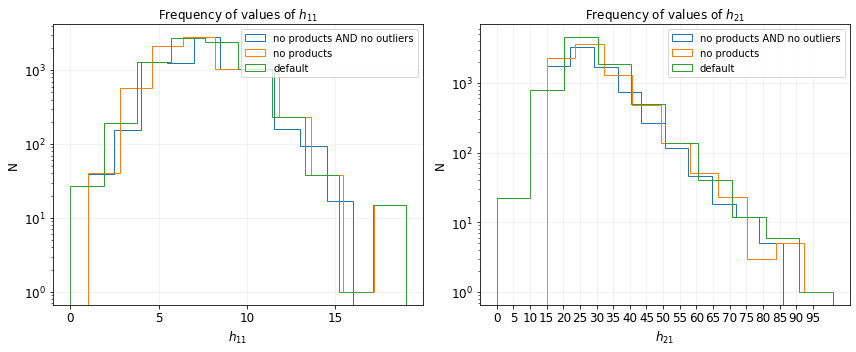

In [14]:
fig, plot = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout()

count_plot(plot[0], df_noprod_noout['h11'], title='Frequency of values of $h_{11}$', xlabel='$h_{11}$', legend='no products AND no outliers', ylog=True)
count_plot(plot[0], df_noprod['h11'],       title='Frequency of values of $h_{11}$', xlabel='$h_{11}$', legend='no products',                 ylog=True)
count_plot(plot[0], df['h11'],              title='Frequency of values of $h_{11}$', xlabel='$h_{11}$', legend='default',                     ylog=True)

count_plot(plot[1], df_noprod_noout['h21'], title='Frequency of values of $h_{21}$', xlabel='$h_{21}$', legend='no products AND no outliers', ylog=True)
count_plot(plot[1], df_noprod['h21'],       title='Frequency of values of $h_{21}$', xlabel='$h_{21}$', legend='no products',                 ylog=True)
count_plot(plot[1], df['h21'],              title='Frequency of values of $h_{21}$', xlabel='$h_{21}$', legend='default',                     ylog=True)

save_fig('h11_h21_occurrencies_original')
plt.show()
plt.close(fig)

We then show the occurrencies of $h_{11}$ and $h_{21}$ with respect to a few features (scalars):


Saving ./img/h11_h21_distributions-comparison_original.png...
Saved ./img/h11_h21_distributions-comparison_original.png!


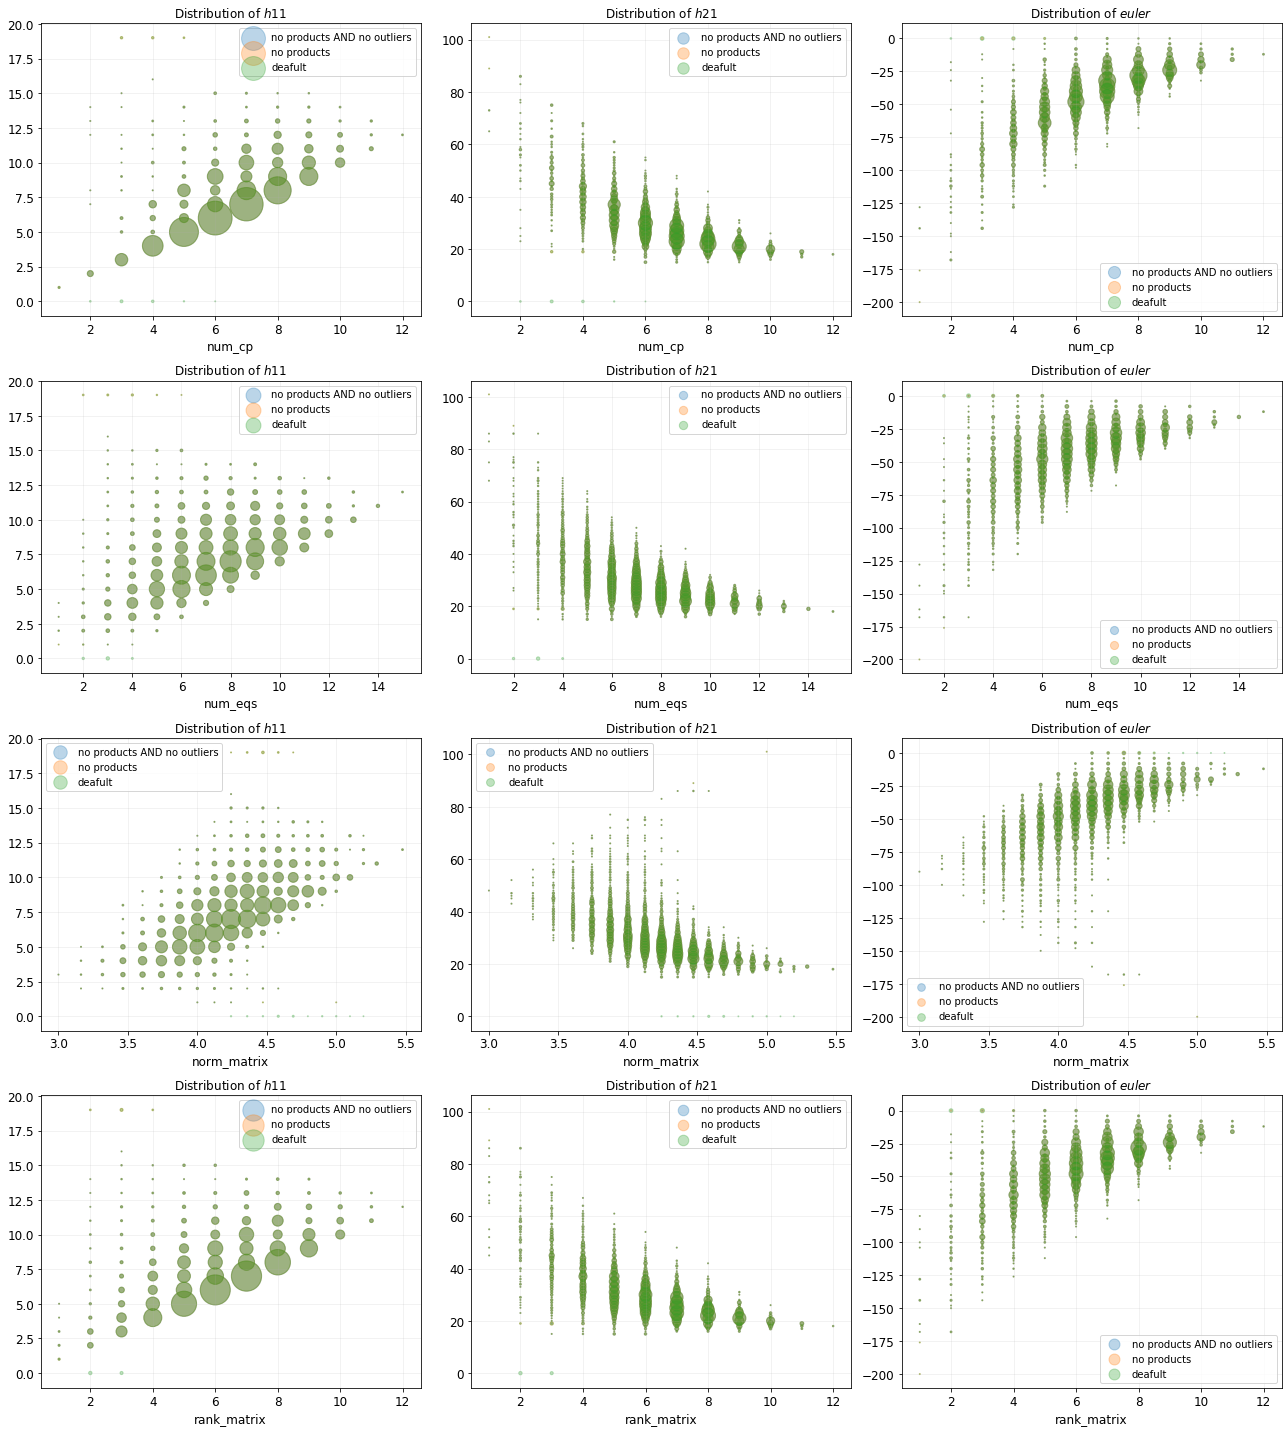


Saving ./img/h11_h21_distributions_original.png...
Saved ./img/h11_h21_distributions_original.png!


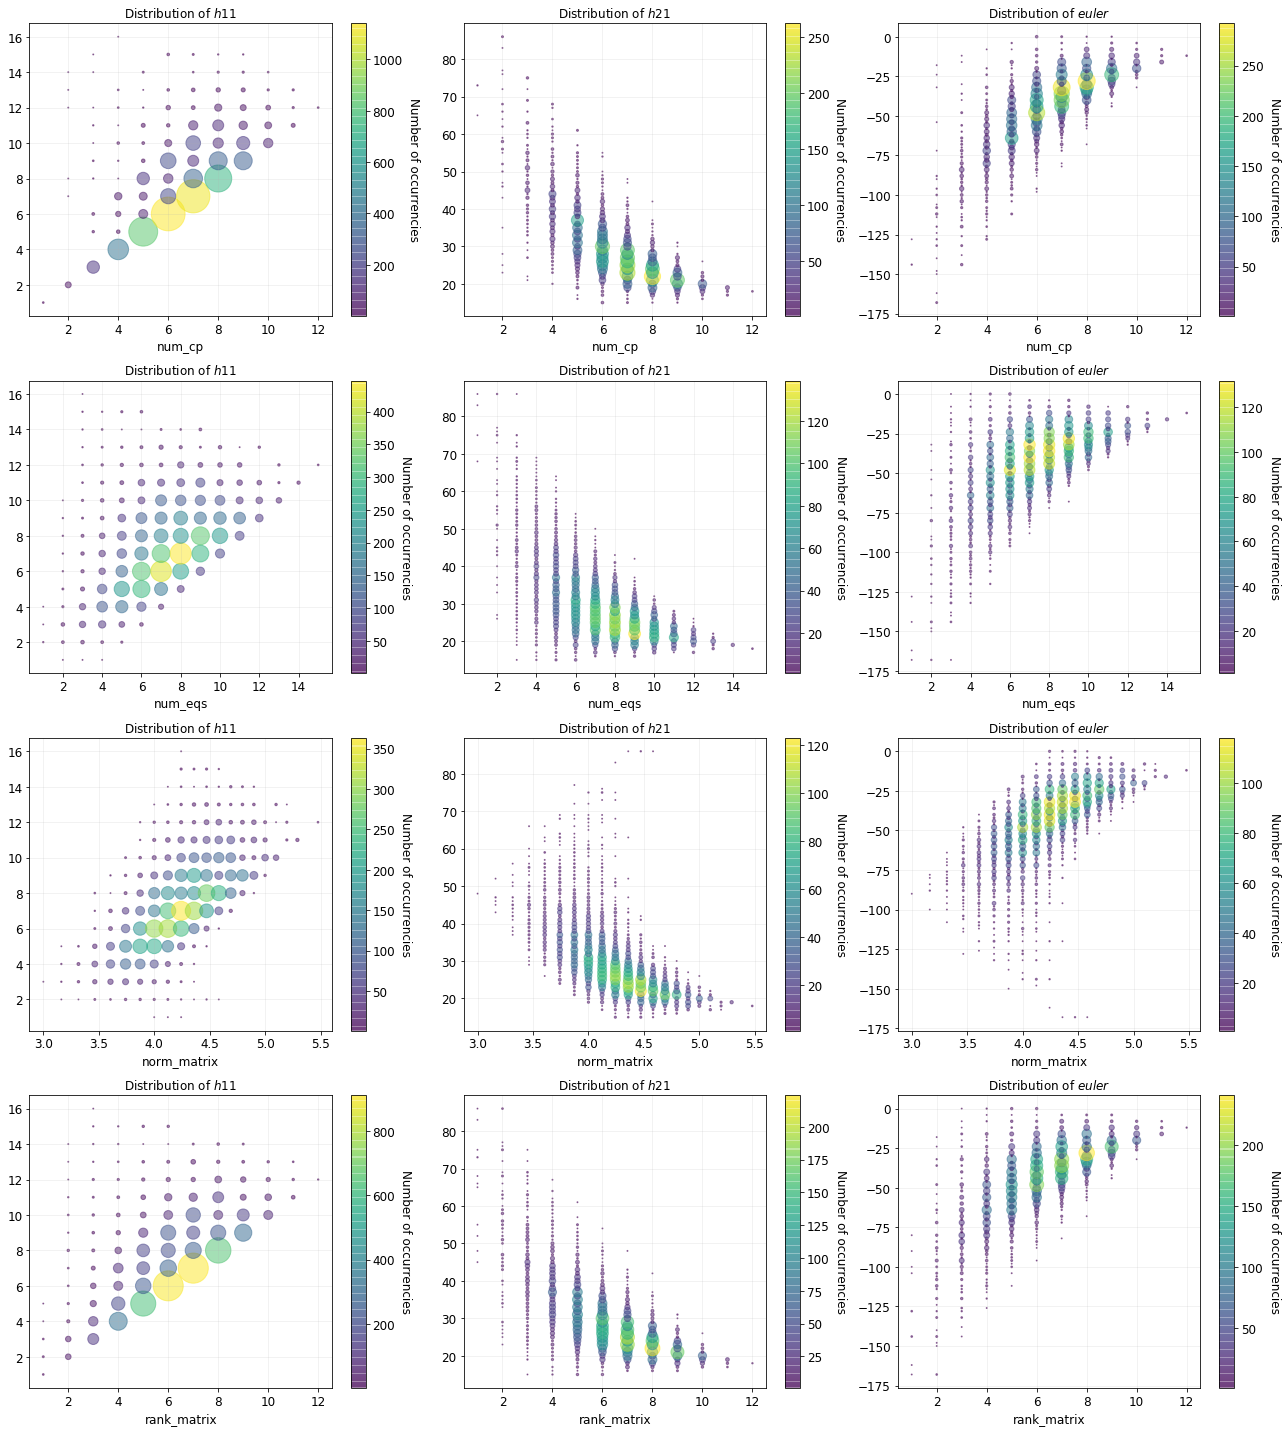

In [15]:
scat_feat = [ 'num_cp', 'num_eqs', 'norm_matrix', 'rank_matrix' ]
scat_labs = [ 'h11', 'h21', 'euler' ]

fig, plot = plt.subplots(len(scat_feat), len(scat_labs), figsize=(6*len(scat_labs),5*len(scat_feat)))
fig.tight_layout()

for n in range(len(scat_feat)):
    for m in range(len(scat_labs)):
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df_noprod_noout, scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=False, legend='no products AND no outliers', alpha=0.3)
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df_noprod,       scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=False, legend='no products',                 alpha=0.3)
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df,              scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=False, legend='deafult',                     alpha=0.3)

save_fig('h11_h21_distributions-comparison_original')
plt.show()
plt.close(fig)

fig, plot = plt.subplots(len(scat_feat), len(scat_labs), figsize=(6*len(scat_labs),5*len(scat_feat)))
fig.tight_layout()

for n in range(len(scat_feat)):
    for m in range(len(scat_labs)):
        scatter_plot(plot[n,m], list(np.asarray(list(get_counts(df_noprod_noout, scat_labs[m], scat_feat[n]))).T), title='Distribution of ${}$'.format(scat_labs[m]), xlabel=scat_feat[n], size=True, colour=True, colour_label='Number of occurrencies', alpha=0.5)

save_fig('h11_h21_distributions_original')
plt.show()
plt.close(fig)

### Feature Selection

We select only the usable columns and divide the data into labels and features:

In [16]:
features_to_drop = list(df_noprod_noout.filter(regex='min_|max_|median_|mean_').columns) + ['c2', 'redun', 'isprod', 'favour', 'size']
df               = df_noprod_noout.drop(labels=features_to_drop, axis=1)

labels      = ['h11', 'h21', 'euler']
df_features = df.drop(labels=labels, axis=1)
df_labels   = df[labels]

We then divide scalar, vector and tensor features in order to process them separately:

In [17]:
scalar_features = list(df_features.select_dtypes(include=['int8', 'int64', 'float64']).columns)
vector_features = list(df_features.drop(labels='matrix', axis=1).select_dtypes(include=['object']).columns)
tensor_features = list(df_features.drop(labels=vector_features, axis=1).select_dtypes(include=['object']).columns)

We then extract the sparse tensors and vectors from their dense definitions:

In [18]:
for feature in vector_features:
    df_features[feature] = ExtractTensor(flatten=False).fit_transform(df_features[feature])
for feature in tensor_features:
    df_features[feature] = ExtractTensor(flatten=False).fit_transform(df_features[feature])
    
df_features = df_features[scalar_features + vector_features + tensor_features] # this is a simple reorder of the dataframe

As a reference, we also plot the correlation matrix of the scalar features and the labels:


Saving ./img/correlation_matrix.png...
Saved ./img/correlation_matrix.png!


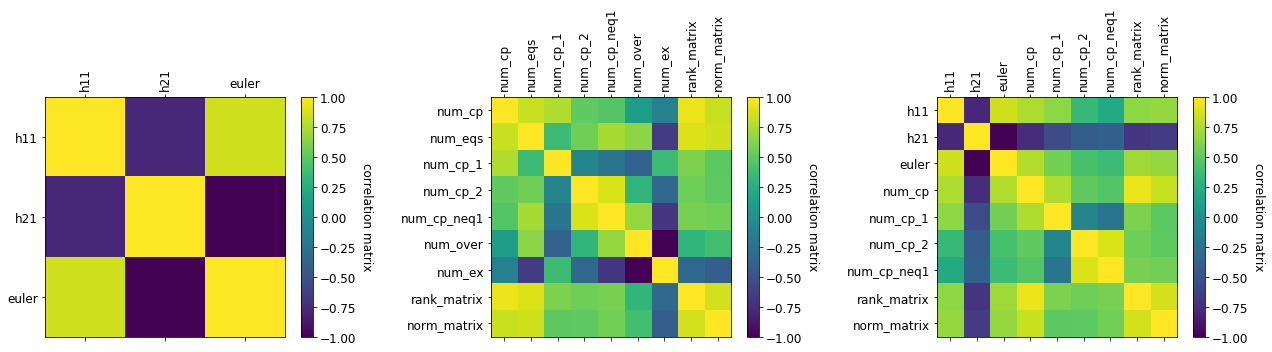

In [19]:
fig, plot = plt.subplots(1, 3, figsize=(18,5))
fig.tight_layout()

mat_plot(plot[0], df_labels)
mat_plot(plot[1], df_features[scalar_features])
mat_plot(plot[2], df_features.join(df_labels)[labels + [ 'num_cp', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'rank_matrix', 'norm_matrix' ] ])

save_fig('correlation_matrix')
plt.show()
plt.close(fig)

We can then mark the dataframe as "production-ready" and save it to file:

In [20]:
DB_PROD_NAME = DB_NAME + '_features_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df_features.to_hdf(DB_PROD_PATH, key='df')

DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df_labels.to_hdf(DB_PROD_PATH, key='df')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs', 'dim_h0_amb',
       'matrix'],
      dtype='object')]

  encoding=encoding,


## Feature Engineering

We now consider the further engineering of the feature space: we consider Kmeans clustering and PCA on the matrix components and then look at the importance of the features in order to select only the relevant ones.

### Clustering analysis

Consider the clustering analysis on the matrix components in order to gain more insight on the relevance of the data:

In [21]:
DB_PROD_NAME = DB_NAME + '_features_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the database!')

Now extract the flattened matrix components:

In [22]:
df['matrix_flat'] = ExtractTensor(flatten=True).fit_transform(df['matrix'])

Then compute the labels of the clustering algorithm with $n$ clusters for $n \in \lbrace 2, ... \rbrace$:

In [23]:
cluster_range = range(2,20)
kmeans_labels = np.empty([df['matrix_flat'].shape[0], len(cluster_range)], dtype='int32')

for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=RAND, n_jobs=-1)
    kmeans.fit_transform(np.stack(df['matrix_flat']))
    kmeans_labels[:,n-min(cluster_range)] = kmeans.labels_

df['clustering'] = list(kmeans_labels)

df = df[scalar_features + ['clustering'] + vector_features + tensor_features] # simple reorder of the dataframe

Then save the dataframe to file (we start to create an "analysis-ready" file which will be overwritten every time we add features or we select others):

In [24]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df.to_hdf(DB_PROD_PATH, key='df')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['clustering', 'dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs',
       'dim_h0_amb', 'matrix'],
      dtype='object')]

  encoding=encoding,


### PCA Analysis

We then move to the PCA on the matrix in order to study the relevance of its components. We also plot the distribution of $h_{11}$ and $h_{21}$ on the 2 principal components of the matrix.

In [25]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the database!')

Now extract the flattened matrix components:

In [26]:
df['matrix_flat'] = ExtractTensor(flatten=True).fit_transform(df['matrix'])

Then apply PCA with 2 components (keep it separate, since it is not really useful for the analysis) and 99% of the variance:

In [27]:
pca2             = PCA(n_components=2, random_state=RAND)
matrix_pca_2     = pca2.fit_transform(np.stack(df['matrix_flat']))
matrix_pca_2_var = pca2.explained_variance_ratio_
print('Variance for 2 components PCA: {:.3f}% for the first component, {:.3f}% for the second component'.format(matrix_pca_2_var[0]*100, matrix_pca_2_var[1]*100))

df['matrix_pca99'] = list(PCA(n_components=0.99, random_state=RAND).fit_transform(np.stack(df['matrix_flat'])))
print('No. of components of the PCA matrix with 99% variance preserved: {:d}'.format(df['matrix_pca99'].apply(np.shape).unique()[0][0]))

df = df[scalar_features + ['clustering'] + vector_features + tensor_features + ['matrix_pca99']] # simple reorder of the dataframe

Variance for 2 components PCA: 9.087% for the first component, 5.594% for the second component
No. of components of the PCA matrix with 99% variance preserved: 81


Then save the dataframe to file:

In [28]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
df.to_hdf(DB_PROD_PATH, key='df')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['clustering', 'dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs',
       'dim_h0_amb', 'matrix', 'matrix_pca99'],
      dtype='object')]

  encoding=encoding,


Then plot the distribution of $h_{11}$ and $h_{21}$ with respect to the 2 principal directions of the PCA:


Saving ./img/h11_h21_pca_distribution_original.png...
Saved ./img/h11_h21_pca_distribution_original.png!


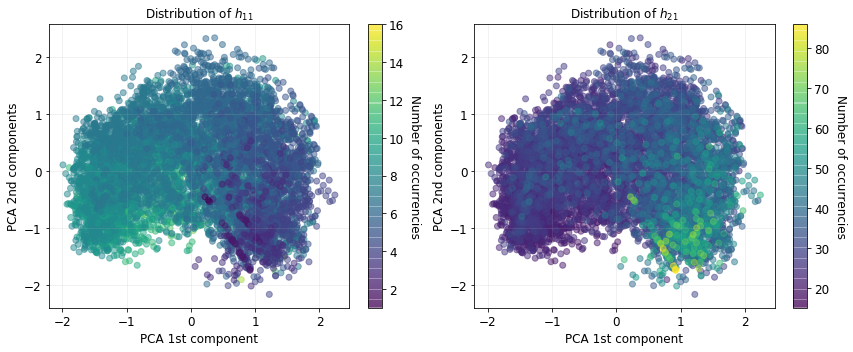

In [29]:
DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df_labels = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the database!')

fig, plot = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout()

scatter_plot(plot[0], [ matrix_pca_2[:,0], matrix_pca_2[:,1], df_labels['h11'] ], title='Distribution of $h_{11}$', xlabel='PCA 1st component', ylabel='PCA 2nd components', size=False, colour=True, colour_label='Number of occurrencies', alpha=0.5)
scatter_plot(plot[1], [ matrix_pca_2[:,0], matrix_pca_2[:,1], df_labels['h21'] ], title='Distribution of $h_{21}$', xlabel='PCA 1st component', ylabel='PCA 2nd components', size=False, colour=True, colour_label='Number of occurrencies', alpha=0.5)

save_fig('h11_h21_pca_distribution_original')
plt.show()
plt.close(fig)

### Feature Importances (Random Forest/Decision Tree)

We now use a Random Forest (or simple Decision Tree) to evaluate the importance of the features used in the dataframe. We then choose whether to drop some of them and which one to take into more consideration. Since this is mostly a qualitative analysis, we operate on the entire set and withouth a deep optimization.

In [30]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the features database!')
    
DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df_labels = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the labels database!')

Create a matrix to hold all the features to be fed to the Decision Tree:

In [31]:
dtree_features = df[scalar_features].values
for feature in ['clustering'] + vector_features:
    dtree_features = np.c_[dtree_features, ExtractTensor(flatten=True).fit_transform(df[feature])]
for feature in tensor_features + ['matrix_pca99']:
    dtree_features = np.c_[dtree_features, ExtractTensor(flatten=True).fit_transform(df[feature])]

Then create the Decision Tree and train it:

In [32]:
params = { 'criterion':    'mse',
           'n_estimators': 32,
           'n_jobs':       -1,
           'random_state': RAND
         }

dtree_h11 = RandomForestRegressor(**params)
print('Fitting for h_11...')
dtree_h11.fit(dtree_features, df_labels['h11'])

dtree_h21 = RandomForestRegressor(**params)
print('Fitting for h_21...')
dtree_h21.fit(dtree_features, df_labels['h21'])

# check accuracy just "for fun"
print('Accuracy for h_11: {:.3f}%'.format(accuracy_score(df_labels['h11'].values, dtree_h11.predict(dtree_features))*100))
print('Accuracy for h_21: {:.3f}%'.format(accuracy_score(df_labels['h21'].values, dtree_h21.predict(dtree_features))*100))

Fitting for h_11...
Fitting for h_21...
Accuracy for h_11: 90.715%
Accuracy for h_21: 57.903%


We then plot the feature importances together with their labels:


Saving ./img/feature_importances_original.png...
Saved ./img/feature_importances_original.png!


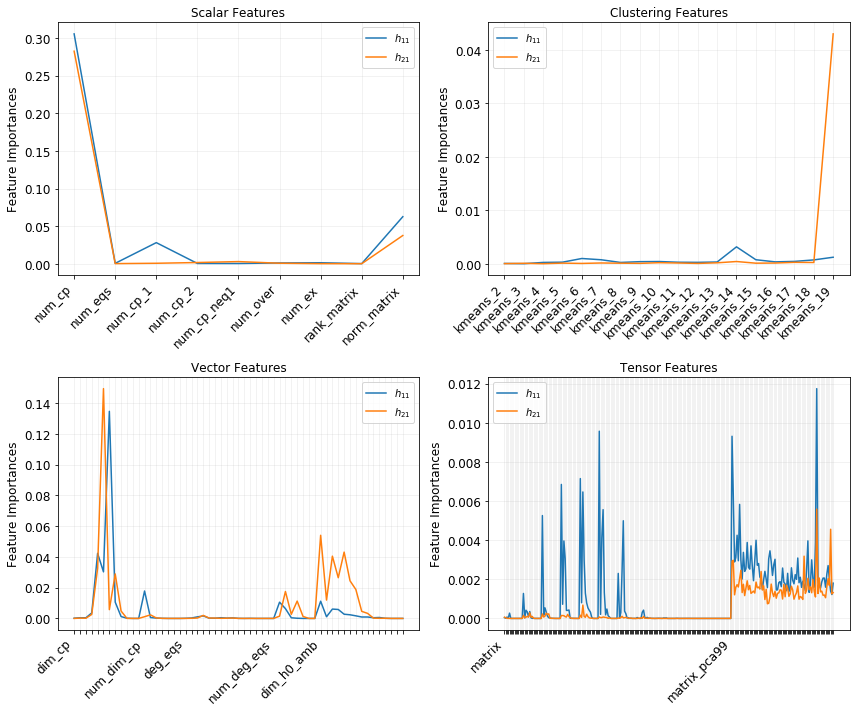

In [33]:
feature_extended_labels = []
for column in df:
    length = np.prod(df[column].values[0].shape).astype(int)
    if column == 'clustering':
        for n in range(length):
            feature_extended_labels.append('kmeans_{:d}'.format(min(cluster_range)+n))
    else:
        feature_extended_labels.append(column)
        for n in range(length-1):
            feature_extended_labels.append('')

importances_h11 = list(zip(feature_extended_labels, dtree_h11.feature_importances_))
importances_h21 = list(zip(feature_extended_labels, dtree_h21.feature_importances_))

fig, plot = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

label_plot(plot[0,0], importances_h11[0:9], title='Scalar Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[0,0], importances_h21[0:9], title='Scalar Features', ylabel='Feature Importances', legend='$h_{21}$')

label_plot(plot[0,1], importances_h11[9:27], title='Clustering Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[0,1], importances_h21[9:27], title='Clustering Features', ylabel='Feature Importances', legend='$h_{21}$')

label_plot(plot[1,0], importances_h11[27:84], title='Vector Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[1,0], importances_h21[27:84], title='Vector Features', ylabel='Feature Importances', legend='$h_{21}$')

label_plot(plot[1,1], importances_h11[84:], title='Tensor Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[1,1], importances_h21[84:], title='Tensor Features', ylabel='Feature Importances', legend='$h_{21}$')

save_fig('feature_importances_original')
plt.show()
plt.close(fig)

We then show more detailed plots summing importances of vector and tensor features:


Saving ./img/feature_importances_vector_tensor_sum_original.png...
Saved ./img/feature_importances_vector_tensor_sum_original.png!


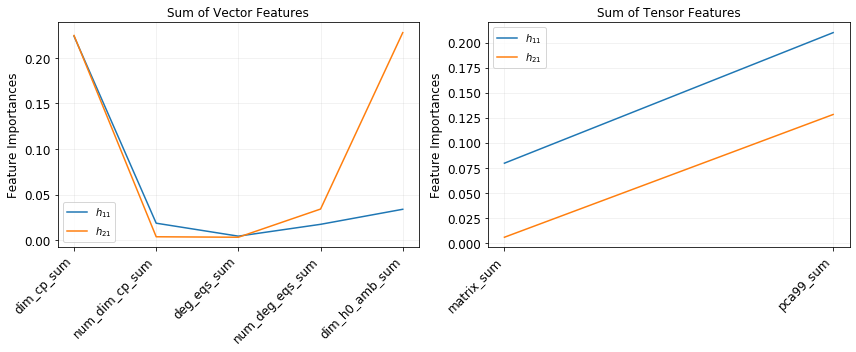

In [34]:
vector_importances_h11_sum = [ ('dim_cp_sum',      np.sum([ f[1] for f in importances_h11[27:39] ]) ),
                               ('num_dim_cp_sum',  np.sum([ f[1] for f in importances_h11[39:46] ]) ),
                               ('deg_eqs_sum',     np.sum([ f[1] for f in importances_h11[46:61] ]) ),
                               ('num_deg_eqs_sum', np.sum([ f[1] for f in importances_h11[61:69] ]) ),
                               ('dim_h0_amb_sum',  np.sum([ f[1] for f in importances_h11[69:84] ]) )
                             ]
vector_importances_h21_sum = [ ('dim_cp_sum',      np.sum([ f[1] for f in importances_h21[27:39] ]) ),
                               ('num_dim_cp_sum',  np.sum([ f[1] for f in importances_h21[39:46] ]) ),
                               ('deg_eqs_sum',     np.sum([ f[1] for f in importances_h21[46:61] ]) ),
                               ('num_deg_eqs_sum', np.sum([ f[1] for f in importances_h21[61:69] ]) ),
                               ('dim_h0_amb_sum',  np.sum([ f[1] for f in importances_h21[69:84] ]) )
                             ]

tensor_importances_h11_sum = [ ('matrix_sum',      np.sum([ f[1] for f in importances_h11[84:264] ]) ),
                               ('pca99_sum',       np.sum([ f[1] for f in importances_h11[264:] ]) )
                             ]
tensor_importances_h21_sum = [ ('matrix_sum',      np.sum([ f[1] for f in importances_h21[84:264] ]) ),
                               ('pca99_sum',       np.sum([ f[1] for f in importances_h21[264:] ]) )
                             ]

fig, plot = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout()

label_plot(plot[0], vector_importances_h11_sum, title='Sum of Vector Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[0], vector_importances_h21_sum, title='Sum of Vector Features', ylabel='Feature Importances', legend='$h_{21}$')

label_plot(plot[1], tensor_importances_h11_sum, title='Sum of Tensor Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot[1], tensor_importances_h21_sum, title='Sum of Tensor Features', ylabel='Feature Importances', legend='$h_{21}$')

save_fig('feature_importances_vector_tensor_sum_original')
plt.show()
plt.close(fig)

Finally we can produce a comparison of tensor, vector and scalar features together:


Saving ./img/feature_importances_sum_original.png...
Saved ./img/feature_importances_sum_original.png!


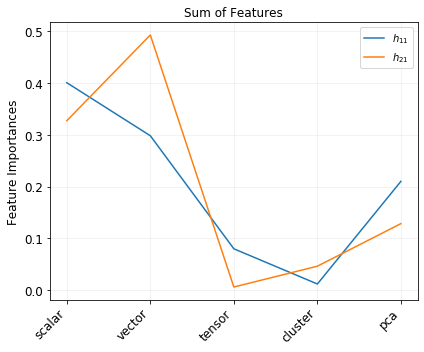

In [35]:
importances_h11_sum = [ ('scalar',  np.sum([ f[1] for f in importances_h11[0:9] ]) ),
                        ('vector',  np.sum([ f[1] for f in importances_h11[27:84] ]) ),
                        ('tensor',  np.sum([ f[1] for f in importances_h11[84:264] ]) ),
                        ('cluster', np.sum([ f[1] for f in importances_h11[9:27] ]) ),
                        ('pca',     np.sum([ f[1] for f in importances_h11[264:] ]) ),
                      ]
importances_h21_sum = [ ('scalar',  np.sum([ f[1] for f in importances_h21[0:9] ]) ),
                        ('vector',  np.sum([ f[1] for f in importances_h21[27:84] ]) ),
                        ('tensor',  np.sum([ f[1] for f in importances_h21[84:264] ]) ),
                        ('cluster', np.sum([ f[1] for f in importances_h21[9:27] ]) ),
                        ('pca',     np.sum([ f[1] for f in importances_h21[264:] ]) ),
                      ]

fig, plot = plt.subplots(figsize=(6,5))
fig.tight_layout()

label_plot(plot, importances_h11_sum, title='Sum of Features', ylabel='Feature Importances', legend='$h_{11}$')
label_plot(plot, importances_h21_sum, title='Sum of Features', ylabel='Feature Importances', legend='$h_{21}$')

save_fig('feature_importances_sum_original')
plt.show()
plt.close(fig)

## Training and Test Data Preparation

On the basis of previous analysis, we are now able to preparare the training and test sets. Specifically we use:

- 90% of the entire dataset for training + validation (in particular 80% for training, 10% for validation)

- 10% of the entire dataset as a test set

The strategy we use for cross-validation is a StratifiedKFold with 9 splits (to keep 10% of the entire dataset).

We then fit the algorithms producing:

- a first baseline using only the `matrix` (the only "known" data at the starting point)

- a second baseline using only `num_cp` (best scalar feature)

- a third baseline using only `dim_cp` (best vector feature)

- the fully engineered sets:

    - `num_cp`, `dim_cp`, `matrix_pca99` for $h_{11}$
    
    - `num_cp`, `dim_cp`, `dim_h0_amb`, `matrix_pca99` for $h_{21}$

In [36]:
DB_PROD_NAME = DB_NAME + '_features_analysis'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the features database!')
    
DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df_labels = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the labels database!')

For simplicity (and since disk space is not an issue, for now) we create separate files for the dataset to be considered:

In [37]:
df_matrix  = np.stack(ExtractTensor(flatten=True).fit_transform(df['matrix']))
df_num_cp  = np.stack(ExtractTensor(flatten=True).fit_transform(df['num_cp']))
df_dim_cp  = np.stack(ExtractTensor(flatten=True).fit_transform(df['dim_cp']))
df_eng_h11 = np.c_[df_num_cp, df_dim_cp, np.stack(ExtractTensor(flatten=True).fit_transform(df['matrix_pca99']))]
df_eng_h21 = np.c_[df_num_cp, df_dim_cp, np.stack(ExtractTensor(flatten=True).fit_transform(df['dim_h0_amb'])), np.stack(ExtractTensor(flatten=True).fit_transform(df['matrix_pca99']))]

print('Saving and compressing datasets...')

DB_PROD_NAME = DB_NAME + '_matrix'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
dump(df_matrix, DB_PROD_PATH, compress=('xz',9))

DB_PROD_NAME = DB_NAME + '_num_cp'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
dump(df_num_cp, DB_PROD_PATH, compress=('xz',9))

DB_PROD_NAME = DB_NAME + '_dim_cp'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
dump(df_dim_cp, DB_PROD_PATH, compress=('xz',9))

DB_PROD_NAME = DB_NAME + '_eng_h11'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
dump(df_eng_h11, DB_PROD_PATH, compress=('xz',9))

DB_PROD_NAME = DB_NAME + '_eng_h21'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
dump(df_eng_h21, DB_PROD_PATH, compress=('xz',9))

print('Datasets have been saved and compressed!')

Saving and compressing datasets...
Datasets have been saved and compressed!


## Machine Learning Analysis

We can now dive into the ML analysis using the previously selected algorithms. First of all, we however define the cross-validation strategy for the analysis:

In [38]:
cv = KFold(n_splits=9, shuffle=True, random_state=RAND)

Furthermore, we split into training and test sets:

In [39]:
DB_PROD_NAME = DB_NAME + '_matrix'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
if path.isfile(DB_PROD_PATH):
    df_matrix = load(DB_PROD_PATH)
else:
    print('Cannot read the matrix database!')
    
DB_PROD_NAME = DB_NAME + '_num_cp'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
if path.isfile(DB_PROD_PATH):
    df_num_cp = load(DB_PROD_PATH)
else:
    print('Cannot read the num_cp database!')
    
DB_PROD_NAME = DB_NAME + '_dim_cp'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
if path.isfile(DB_PROD_PATH):
    df_dim_cp = load(DB_PROD_PATH)
else:
    print('Cannot read the dim_cp database!')
    
DB_PROD_NAME = DB_NAME + '_eng_h11'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
if path.isfile(DB_PROD_PATH):
    df_eng_h11 = load(DB_PROD_PATH)
else:
    print('Cannot read the eng_h11 database!')
    
DB_PROD_NAME = DB_NAME + '_eng_h21'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5.xz')
if path.isfile(DB_PROD_PATH):
    df_eng_h21 = load(DB_PROD_PATH)
else:
    print('Cannot read the eng_h21 database!')
    
DB_PROD_NAME = DB_NAME + '_labels_production'
DB_PROD_PATH = path.join(ROOT_DIR, DB_PROD_NAME + '.h5')
if path.isfile(DB_PROD_PATH):
    df_labels = pd.read_hdf(DB_PROD_PATH)
else:
    print('Cannot read the labels database!')
    
h11_labels   = ExtractTensor(flatten=True).fit_transform(df_labels['h11'])
h21_labels   = ExtractTensor(flatten=True).fit_transform(df_labels['h21'])
euler_labels = ExtractTensor(flatten=True).fit_transform(df_labels['euler'])
    
# Split into training and test sets
df_matrix_train, df_matrix_test, \
df_num_cp_train, df_num_cp_test, \
df_dim_cp_train, df_dim_cp_test, \
df_eng_h11_train, df_eng_h11_test, \
df_eng_h21_train, df_eng_h21_test, \
h11_labels_train, h11_labels_test, \
h21_labels_train, h21_labels_test, \
euler_labels_train, euler_labels_test = train_test_split(df_matrix,
                                                         df_num_cp,
                                                         df_dim_cp,
                                                         df_eng_h11,
                                                         df_eng_h21,
                                                         h11_labels,
                                                         h21_labels,
                                                         euler_labels,
                                                         test_size=0.1,
                                                         random_state=RAND,
                                                         shuffle=True
                                                        )

# Apply StandardScaler to the input
std_scal = StandardScaler()

df_matrix_train  = std_scal.fit_transform(df_matrix_train) # fit only on the training set
df_matrix_test   = std_scal.transform(df_matrix_test)      # just transform the test set

df_num_cp_train  = std_scal.fit_transform(df_num_cp_train.reshape(-1,1))
df_num_cp_test   = std_scal.transform(df_num_cp_test.reshape(-1,1))

df_dim_cp_train  = std_scal.fit_transform(df_dim_cp_train)
df_dim_cp_test   = std_scal.transform(df_dim_cp_test)

df_eng_h11_train = std_scal.fit_transform(df_eng_h11_train)
df_eng_h11_test  = std_scal.transform(df_eng_h11_test)

df_eng_h21_train = std_scal.fit_transform(df_eng_h21_train)
df_eng_h21_test  = std_scal.transform(df_eng_h21_test)

### Linear Regression


Fitting the matrix baseline on h_11...
Best parameters: {'fit_intercept': True, 'normalize': False}
Accuracy (floor) of the cross-validation: (50.177 ± 2.776)%
Accuracy (floor) of the predictions: 52.926%

Fitting the matrix baseline on h_21...
Best parameters: {'fit_intercept': True, 'normalize': False}
Accuracy (floor) of the cross-validation: (10.885 ± 1.296)%
Accuracy (floor) of the predictions: 10.560%

Saving ./img/lin_reg_error_matrix_original.png...
Saved ./img/lin_reg_error_matrix_original.png!


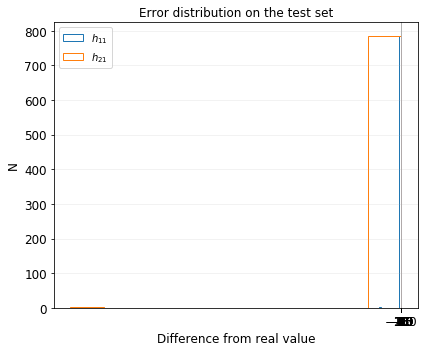


Fitting the num_cp baseline on h_11...
Best parameters: {'fit_intercept': True, 'normalize': True}
Accuracy (floor) of the cross-validation: (62.236 ± 2.237)%
Accuracy (floor) of the predictions: 60.305%

Fitting the num_cp baseline on h_21...
Best parameters: {'fit_intercept': True, 'normalize': True}
Accuracy (floor) of the cross-validation: (7.983 ± 0.594)%
Accuracy (floor) of the predictions: 9.542%

Saving ./img/lin_reg_error_num_cp_original.png...
Saved ./img/lin_reg_error_num_cp_original.png!


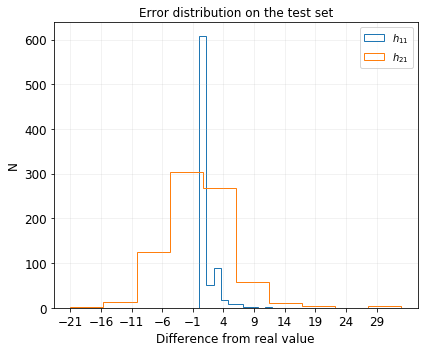


Fitting the dim_cp baseline on h_11...
Best parameters: {'fit_intercept': True, 'normalize': True}
Accuracy (floor) of the cross-validation: (44.034 ± 2.480)%
Accuracy (floor) of the predictions: 45.038%

Fitting the dim_cp baseline on h_21...
Best parameters: {'fit_intercept': True, 'normalize': True}
Accuracy (floor) of the cross-validation: (7.233 ± 1.105)%
Accuracy (floor) of the predictions: 7.634%

Saving ./img/lin_reg_error_dim_cp_original.png...
Saved ./img/lin_reg_error_dim_cp_original.png!


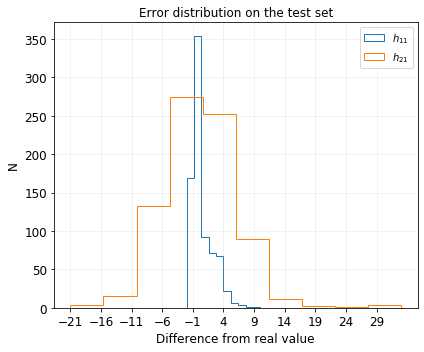


Fitting the feature engineered dataset on h_11...
Best parameters: {'fit_intercept': True, 'normalize': True}
Accuracy (floor) of the cross-validation: (51.975 ± 1.961)%
Accuracy (floor) of the predictions: 53.817%

Fitting the feature engineered dataset on h_21...
Best parameters: {'fit_intercept': True, 'normalize': True}
Accuracy (floor) of the cross-validation: (19.108 ± 1.544)%
Accuracy (floor) of the predictions: 18.957%

Saving ./img/lin_reg_error_eng_original.png...
Saved ./img/lin_reg_error_eng_original.png!


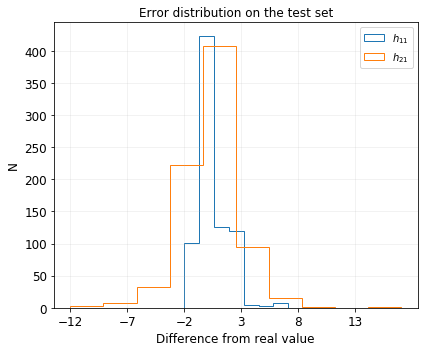


Saving models...
Models saved!


In [43]:
search_params = {'fit_intercept': [ True, False ],
                 'normalize':     [ True, False ]
                }
rounding      = np.floor

lin_reg_h11 = GridSearchCV(estimator=LinearRegression(),
                           param_grid=search_params,
                           scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                           cv=cv,
                           n_jobs=-1,
                           verbose=0
                          )
lin_reg_h21 = GridSearchCV(estimator=LinearRegression(),
                           param_grid=search_params,
                           scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                           cv=cv,
                           n_jobs=-1,
                           verbose=0
                          )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
lin_reg_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(lin_reg_h11, rounding=rounding)
prediction_score(lin_reg_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
lin_reg_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(lin_reg_h21, rounding=rounding)
prediction_score(lin_reg_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_reg_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_reg_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_reg_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
lin_reg_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(lin_reg_h11, rounding=rounding)
prediction_score(lin_reg_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
lin_reg_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(lin_reg_h21, rounding=rounding)
prediction_score(lin_reg_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_reg_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_reg_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_reg_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
lin_reg_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(lin_reg_h11, rounding=rounding)
prediction_score(lin_reg_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
lin_reg_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(lin_reg_h21, rounding=rounding)
prediction_score(lin_reg_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_reg_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_reg_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_reg_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
lin_reg_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(lin_reg_h11, rounding=rounding)
prediction_score(lin_reg_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
lin_reg_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(lin_reg_h21, rounding=rounding)
prediction_score(lin_reg_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_reg_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_reg_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_reg_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'lin_reg_h11.joblib.xz')
dump(lin_reg_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'lin_reg_h21.joblib.xz')
dump(lin_reg_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

### Lasso

In [ ]:
search_params = {'alpha':         Real(1e-6, 1e2, base=10, prior='log-uniform', name='alpha'),
                 'fit_intercept': Integer(False, True, name='fit_intercept'),
                 'normalize':     Integer(False, True, name='normalize'),
                 'positive':      Integer(False, True, name='positive')
                }
rounding      = np.floor
n_iter        = 15

lasso_h11 = BayesSearchCV(estimator=Lasso(max_iter=5000, tol=0.001, random_state=RAND),
                          search_spaces=search_params,
                          n_iter=n_iter,
                          scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                          cv=cv,
                          n_jobs=-1,
                          verbose=0
                         )
lasso_h21 = BayesSearchCV(estimator=Lasso(max_iter=5000, tol=0.001, random_state=RAND),
                          search_spaces=search_params,
                          n_iter=n_iter,
                          scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                          cv=cv,
                          n_jobs=-1,
                          verbose=0
                         )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
lasso_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(lasso_h11, rounding=rounding)
prediction_score(lasso_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
lasso_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(lasso_h21, rounding=rounding)
prediction_score(lasso_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lasso_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lasso_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lasso_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
lasso_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(lasso_h11, rounding=rounding)
prediction_score(lasso_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
lasso_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(lasso_h21, rounding=rounding)
prediction_score(lasso_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lasso_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lasso_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lasso_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
lasso_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(lasso_h11, rounding=rounding)
prediction_score(lasso_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
lasso_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(lasso_h21, rounding=rounding)
prediction_score(lasso_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lasso_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lasso_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lasso_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
lasso_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(lasso_h11, rounding=rounding)
prediction_score(lasso_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
lasso_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(lasso_h21, rounding=rounding)
prediction_score(lasso_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lasso_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lasso_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lasso_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'lasso_h11.joblib.xz')
dump(lasso_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'lasso_h21.joblib.xz')
dump(lasso_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')


Fitting the matrix baseline on h_11...
Best parameters: {'alpha': 2.996309243274199e-05, 'fit_intercept': 1, 'normalize': 1, 'positive': 0}
Accuracy (floor) of the cross-validation: (50.913 ± 2.588)%
Accuracy (floor) of the predictions: 52.290%

Fitting the matrix baseline on h_21...


### Elastic Net

In [ ]:
search_params = {'alpha':         Real(1e-6, 1e2, base=10, prior='log-uniform', name='alpha'),
                 'l1_ratio':      Real(0.0, 1.0,           prior='uniform',     name='l1_ratio'),
                 'fit_intercept': Integer(False, True, name='fit_intercept'),
                 'normalize':     Integer(False, True, name='normalize'),
                 'positive':      Integer(False, True, name='positive')
                }
rounding      = np.floor
n_iter        = 15

el_net_h11 = BayesSearchCV(estimator=ElasticNet(max_iter=5000, tol=0.001, random_state=RAND),
                           search_spaces=search_params,
                           n_iter=n_iter,
                           scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                           cv=cv,
                           n_jobs=-1,
                           verbose=0
                          )
el_net_h21 = BayesSearchCV(estimator=ElasticNet(max_iter=5000, tol=0.001, random_state=RAND),
                           search_spaces=search_params,
                           n_iter=n_iter,
                           scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                           cv=cv,
                           n_jobs=-1,
                           verbose=0
                          )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
el_net_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(el_net_h11, rounding=rounding)
prediction_score(el_net_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
el_net_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(el_net_h21, rounding=rounding)
prediction_score(el_net_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, el_net_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, el_net_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('el_net_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
el_net_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(el_net_h11, rounding=rounding)
prediction_score(el_net_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
el_net_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(el_net_h21, rounding=rounding)
prediction_score(el_net_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, el_net_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, el_net_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('el_net_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
el_net_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(el_net_h11, rounding=rounding)
prediction_score(el_net_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
el_net_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(el_net_h21, rounding=rounding)
prediction_score(el_net_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, el_net_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, el_net_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('el_net_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
el_net_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(el_net_h11, rounding=rounding)
prediction_score(el_net_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
el_net_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(el_net_h21, rounding=rounding)
prediction_score(el_net_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, el_net_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, el_net_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('el_net_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'el_net_h11.joblib.xz')
dump(el_net_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'el_net_h21.joblib.xz')
dump(el_net_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

### Ridge

In [ ]:
search_params = {'alpha':         Real(1e-6, 1e2, base=10, prior='log-uniform', name='alpha'),
                 'fit_intercept': Integer(False, True, name='fit_intercept'),
                 'normalize':     Integer(False, True, name='normalize')
                }
rounding      = np.floor
n_iter        = 15

ridge_h11 = BayesSearchCV(estimator=Ridge(max_iter=5000, random_state=RAND),
                          search_spaces=search_params,
                          n_iter=n_iter,
                          scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                          cv=cv,
                          n_jobs=-1,
                          verbose=0
                         )
ridge_h21 = BayesSearchCV(estimator=Ridge(max_iter=5000, random_state=RAND),
                          search_spaces=search_params,
                          n_iter=n_iter,
                          scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                          cv=cv,
                          n_jobs=-1,
                          verbose=0
                         )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
ridge_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(ridge_h11, rounding=rounding)
prediction_score(ridge_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
ridge_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(ridge_h21, rounding=rounding)
prediction_score(ridge_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, ridge_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, ridge_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('ridge_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
ridge_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(ridge_h11, rounding=rounding)
prediction_score(ridge_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
ridge_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(ridge_h21, rounding=rounding)
prediction_score(ridge_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, ridge_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, ridge_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('ridge_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
ridge_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(ridge_h11, rounding=rounding)
prediction_score(ridge_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
ridge_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(ridge_h21, rounding=rounding)
prediction_score(ridge_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, ridge_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, ridge_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('ridge_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
ridge_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(ridge_h11, rounding=rounding)
prediction_score(ridge_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
ridge_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(ridge_h21, rounding=rounding)
prediction_score(ridge_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, ridge_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, ridge_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('ridge_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'ridge_h11.joblib.xz')
dump(ridge_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'ridge_h21.joblib.xz')
dump(ridge_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

### Linear SVR

In [ ]:
search_params = {'C':                 Real(1e-4, 1e4, base=10, prior='log-uniform', name='C'),
                 'intercept_scaling': Real(1e-2, 1e2, base=10, prior='log-uniform', name='intercept_scaling'),
                 'fit_intercept':     Integer(False, True, name='fit_intercept'),
                 'loss':              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'], name='loss')
                }
rounding      = np.floor
n_iter        = 15

lin_svr_h11 = BayesSearchCV(estimator=LinearSVR(max_iter=5000, tol=0.001, random_state=RAND),
                            search_spaces=search_params,
                            n_iter=n_iter,
                            scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                            cv=cv,
                            n_jobs=-1,
                            verbose=0
                           )
lin_svr_h21 = BayesSearchCV(estimator=LinearSVR(max_iter=5000, tol=0.001, random_state=RAND),
                            search_spaces=search_params,
                            n_iter=n_iter,
                            scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                            cv=cv,
                            n_jobs=-1,
                            verbose=0
                           )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
lin_svr_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(lin_svr_h11, rounding=rounding)
prediction_score(lin_svr_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
lin_svr_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(lin_svr_h21, rounding=rounding)
prediction_score(lin_svr_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_svr_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_svr_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_svr_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
lin_svr_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(lin_svr_h11, rounding=rounding)
prediction_score(lin_svr_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
lin_svr_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(lin_svr_h21, rounding=rounding)
prediction_score(lin_svr_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_svr_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_svr_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_svr_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
lin_svr_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(lin_svr_h11, rounding=rounding)
prediction_score(lin_svr_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
lin_svr_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(lin_svr_h21, rounding=rounding)
prediction_score(lin_svr_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_svr_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_svr_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_svr_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
lin_svr_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(lin_svr_h11, rounding=rounding)
prediction_score(lin_svr_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
lin_svr_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(lin_svr_h21, rounding=rounding)
prediction_score(lin_svr_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, lin_svr_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, lin_svr_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('lin_svr_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'lin_svr_h11.joblib.xz')
dump(lin_svr_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'lin_svr_h21.joblib.xz')
dump(lin_svr_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

### SVR(rbf)

In [ ]:
search_params = {'C':         Real(1e-4, 1e4, base=10, prior='log-uniform', name='C'),
                 'gamma':     Real(1e-6, 1e2, base=10, prior='log-uniform', name='gamma'),
                 'epsilon':   Real(1e-5, 1e1, base=10, prior='log-uniform', name='epsilon'),
                 'shrinking': Integer(False, True, name='shrinking')
                }
rounding      = np.rint
n_iter        = 15

svr_rbf_h11 = BayesSearchCV(estimator=SVR(kernel='rbf', max_iter=5000),
                            search_spaces=search_params,
                            n_iter=n_iter,
                            scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                            cv=cv,
                            n_jobs=-1,
                            verbose=0
                           )
svr_rbf_h21 = BayesSearchCV(estimator=SVR(kernel='rbf', max_iter=5000),
                            search_spaces=search_params,
                            n_iter=n_iter,
                            scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                            cv=cv,
                            n_jobs=-1,
                            verbose=0
                           )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
svr_rbf_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(svr_rbf_h11, rounding=rounding)
prediction_score(svr_rbf_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
svr_rbf_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(svr_rbf_h21, rounding=rounding)
prediction_score(svr_rbf_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, svr_rbf_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, svr_rbf_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('svr_rbf_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
svr_rbf_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(svr_rbf_h11, rounding=rounding)
prediction_score(svr_rbf_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
svr_rbf_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(svr_rbf_h21, rounding=rounding)
prediction_score(svr_rbf_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, svr_rbf_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, svr_rbf_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('svr_rbf_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
svr_rbf_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(svr_rbf_h11, rounding=rounding)
prediction_score(svr_rbf_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
svr_rbf_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(svr_rbf_h21, rounding=rounding)
prediction_score(svr_rbf_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, svr_rbf_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, svr_rbf_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('svr_rbf_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
svr_rbf_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(svr_rbf_h11, rounding=rounding)
prediction_score(svr_rbf_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
svr_rbf_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(svr_rbf_h21, rounding=rounding)
prediction_score(svr_rbf_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, svr_rbf_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, svr_rbf_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('svr_rbf_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'svr_rbf_h11.joblib.xz')
dump(svr_rbf_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'svr_rbf_h21.joblib.xz')
dump(svr_rbf_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

### Gradient Boosted Tree

In [ ]:
search_params = {'loss':                     Categorical(['ls', 'lad', 'huber'],           name='loss'),
                 'criterion':                Categorical(['friedman_mse', 'mse', 'mae'],   name='criterion'),
                 'max_features':             Categorical(['auto', 'sqrt', 'log2'],         name='max_features'),
                 'learning_rate':            Real(1e-3, 1e1, base=10, prior='log-uniform', name='learning_rate'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5,           prior='uniform',     name='min_weight_fraction_leaf'),
                 'min_impurity_decrease':    Real(0.0, 1.0,           prior='uniform',     name='min_impurity_decrease'),
                 'alpha':                    Real(0.0, 0.99,          prior='uniform',     name='alpha'),
                 'n_estimators':             Integer(1e1, 1e3,        prior='uniform',     name='n_estimators'),
                 'min_samples_split':        Integer(2, 100,          prior='uniform',     name='min_samples_split'),
                 'min_samples_leaf':         Integer(1, 50,           prior='uniform',     name='min_samples_leaf'),
                 'max_depth':                Integer(2, 50,           prior='uniform',     name='max_depth')
                }
rounding      = np.floor
n_iter        = 15

grd_boost_h11 = BayesSearchCV(estimator=GradientBoostingRegressor(tol=0.001, random_state=RAND),
                              search_spaces=search_params,
                              n_iter=n_iter,
                              scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                              cv=cv,
                              n_jobs=-1,
                              verbose=0
                             )
grd_boost_h21 = BayesSearchCV(estimator=GradientBoostingRegressor(tol=0.001, random_state=RAND),
                              search_spaces=search_params,
                              n_iter=n_iter,
                              scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                              cv=cv,
                              n_jobs=-1,
                              verbose=0
                             )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
grd_boost_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(grd_boost_h11, rounding=rounding)
prediction_score(grd_boost_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
grd_boost_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(grd_boost_h21, rounding=rounding)
prediction_score(grd_boost_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, grd_boost_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, grd_boost_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('grd_boost_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
grd_boost_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(grd_boost_h11, rounding=rounding)
prediction_score(grd_boost_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
grd_boost_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(grd_boost_h21, rounding=rounding)
prediction_score(grd_boost_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, grd_boost_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, grd_boost_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('grd_boost_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
grd_boost_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(grd_boost_h11, rounding=rounding)
prediction_score(grd_boost_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
grd_boost_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(grd_boost_h21, rounding=rounding)
prediction_score(grd_boost_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, grd_boost_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, grd_boost_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('grd_boost_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
grd_boost_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(grd_boost_h11, rounding=rounding)
prediction_score(grd_boost_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
grd_boost_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(grd_boost_h21, rounding=rounding)
prediction_score(grd_boost_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, grd_boost_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, grd_boost_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('grd_boost_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'grd_boost_h11.joblib.xz')
dump(grd_boost_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'grd_boost_h21.joblib.xz')
dump(grd_boost_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

### Random Forest

In [ ]:
search_params = {'loss':                     Categorical(['ls', 'lad', 'huber'],           name='loss'),
                 'criterion':                Categorical(['mse', 'mae'],                   name='criterion'),
                 'max_features':             Categorical(['auto', 'sqrt', 'log2'],         name='max_features'),
                 'learning_rate':            Real(1e-3, 1e1, base=10, prior='log-uniform', name='learning_rate'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5,           prior='uniform',     name='min_weight_fraction_leaf'),
                 'min_impurity_decrease':    Real(0.0, 1.0,           prior='uniform',     name='min_impurity_decrease'),
                 'alpha':                    Real(0.0, 0.99,          prior='uniform',     name='alpha'),
                 'n_estimators':             Integer(1e1, 1e3,        prior='uniform',     name='n_estimators'),
                 'min_samples_split':        Integer(2, 100,          prior='uniform',     name='min_samples_split'),
                 'min_samples_leaf':         Integer(1, 50,           prior='uniform',     name='min_samples_leaf'),
                 'max_depth':                Integer(2, 50,           prior='uniform',     name='max_depth')
                }
rounding      = np.floor
n_iter        = 15

rnd_for_h11 = BayesSearchCV(estimator=RandomForestRegressor(random_state=RAND),
                            search_spaces=search_params,
                            n_iter=n_iter,
                            scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                            cv=cv,
                            n_jobs=-1,
                            verbose=0
                           )
rnd_for_h21 = BayesSearchCV(estimator=RandomForestRegressor(random_state=RAND),
                            search_spaces=search_params,
                            n_iter=n_iter,
                            scoring=make_scorer(accuracy_score, greater_is_better=True, rounding=rounding),
                            cv=cv,
                            n_jobs=-1,
                            verbose=0
                           )

#####################################
# MATRIX BASELINE                   #
#####################################
print('\nFitting the matrix baseline on h_11...')
rnd_for_h11.fit(df_matrix_train, h11_labels_train)
gridcv_score(rnd_for_h11, rounding=rounding)
prediction_score(rnd_for_h11, df_matrix_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the matrix baseline on h_21...')
rnd_for_h21.fit(df_matrix_train, h21_labels_train)
gridcv_score(rnd_for_h21, rounding=rounding)
prediction_score(rnd_for_h21, df_matrix_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, rnd_for_h11.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, rnd_for_h21.best_estimator_.predict(df_matrix_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('rnd_for_error_matrix_original')
plt.show()
plt.close(fig)

#####################################
# NUM_CP BASELINE                   #
#####################################
print('\nFitting the num_cp baseline on h_11...')
rnd_for_h11.fit(df_num_cp_train, h11_labels_train)
gridcv_score(rnd_for_h11, rounding=rounding)
prediction_score(rnd_for_h11, df_num_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the num_cp baseline on h_21...')
rnd_for_h21.fit(df_num_cp_train, h21_labels_train)
gridcv_score(rnd_for_h21, rounding=rounding)
prediction_score(rnd_for_h21, df_num_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, rnd_for_h11.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, rnd_for_h21.best_estimator_.predict(df_num_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('rnd_for_error_num_cp_original')
plt.show()
plt.close(fig)

#####################################
# DIM_CP BASELINE                   #
#####################################
print('\nFitting the dim_cp baseline on h_11...')
rnd_for_h11.fit(df_dim_cp_train, h11_labels_train)
gridcv_score(rnd_for_h11, rounding=rounding)
prediction_score(rnd_for_h11, df_dim_cp_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the dim_cp baseline on h_21...')
rnd_for_h21.fit(df_dim_cp_train, h21_labels_train)
gridcv_score(rnd_for_h21, rounding=rounding)
prediction_score(rnd_for_h21, df_dim_cp_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, rnd_for_h11.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, rnd_for_h21.best_estimator_.predict(df_dim_cp_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('rnd_for_error_dim_cp_original')
plt.show()
plt.close(fig)

#####################################
# FEATURE ENGINEERING               #
#####################################
print('\nFitting the feature engineered dataset on h_11...')
rnd_for_h11.fit(df_eng_h11_train, h11_labels_train)
gridcv_score(rnd_for_h11, rounding=rounding)
prediction_score(rnd_for_h11, df_eng_h11_test, h11_labels_test, use_best_estimator=True, rounding=rounding)

print('\nFitting the feature engineered dataset on h_21...')
rnd_for_h21.fit(df_eng_h21_train, h21_labels_train)
gridcv_score(rnd_for_h21, rounding=rounding)
prediction_score(rnd_for_h21, df_eng_h21_test, h21_labels_test, use_best_estimator=True, rounding=rounding)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, rnd_for_h11.best_estimator_.predict(df_eng_h11_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')
count_plot(plot, error_diff(h21_labels_test, rnd_for_h21.best_estimator_.predict(df_eng_h21_test), rounding=rounding), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('rnd_for_error_eng_original')
plt.show()
plt.close(fig)

# Saving the feature engineered models
print('\nSaving models...')
MOD_FILE = path.join(MOD_PATH, 'rnd_for_h11.joblib.xz')
dump(rnd_for_h11.best_estimator_, MOD_FILE, compress=('xz',9))
MOD_FILE = path.join(MOD_PATH, 'rnd_for_h21.joblib.xz')
dump(rnd_for_h21.best_estimator_, MOD_FILE, compress=('xz',9))
print('Models saved!')

## Neural Networks

Using [Tensorflow-Keras](https://www.tensorflow.org/api_docs/python/tf/keras) we train a CNN and a DNN to predict the values of $h_{11}$ and $h_{21}$. The first approach will be to use a Sequential model taking only the configuration matrix as input, and then a Functional API Model taking as input the feature engineered version of the dataframe.

We first need to set aside a validation set and to reshape the matrix input for a Conv2D layer. We also take the opportunity to cast everything into Tensorflow vectors.

In [ ]:
df_matrix_cnn_train = df_matrix_train.reshape(-1,12,15,1)
df_matrix_cnn_test  = df_matrix_test.reshape(-1,12,15,1)

# Split into training and validation set
df_matrix_cnn_train, df_matrix_cnn_val, \
df_num_cp_train, df_num_cp_val, \
df_dim_cp_train, df_dim_cp_val, \
df_eng_h11_train, df_eng_h11_val, \
df_eng_h21_train, df_eng_h21_val, \
h11_labels_train, h11_labels_val, \
h21_labels_train, h21_labels_val, \
euler_labels_train, euler_labels_val = train_test_split(df_matrix_cnn_train,
                                                        df_num_cp_train,
                                                        df_dim_cp_train,
                                                        df_eng_h11_train,
                                                        df_eng_h21_train,
                                                        h11_labels_train,
                                                        h21_labels_train,
                                                        euler_labels_train,
                                                        test_size=1/9,
                                                        random_state=RAND
                                                       )

# Cast into Tensorflow vectors
# df_matrix_cnn_train = K.cast(df_matrix_cnn_train, dtype='float64')
# df_num_cp_train     = K.cast(df_num_cp_train, dtype='float64')
# df_dim_cp_train     = K.cast(df_dim_cp_train, dtype='float64')
# df_eng_h11_train    = K.cast(df_eng_h11_train, dtype='float64')
# df_eng_h21_train    = K.cast(df_eng_h21_train, dtype='float64')

# df_matrix_cnn_val   = K.cast(df_matrix_cnn_val, dtype='float64')
# df_num_cp_val       = K.cast(df_num_cp_val, dtype='float64')
# df_dim_cp_val       = K.cast(df_dim_cp_val, dtype='float64')
# df_eng_h11_val      = K.cast(df_eng_h11_val, dtype='float64')
# df_eng_h21_val      = K.cast(df_eng_h21_val, dtype='float64')

# df_matrix_cnn_test  = K.cast(df_matrix_cnn_test, dtype='float64')
# df_num_cp_test      = K.cast(df_num_cp_test, dtype='float64')
# df_dim_cp_test      = K.cast(df_dim_cp_test, dtype='float64')
# df_eng_h11_test     = K.cast(df_eng_h11_test, dtype='float64')
# df_eng_h21_test     = K.cast(df_eng_h21_test, dtype='float64')

# h11_labels_train    = K.cast(h11_labels_train, dtype='float64')
# h21_labels_train    = K.cast(h21_labels_train, dtype='float64')
# euler_labels_train  = K.cast(euler_labels_train, dtype='float64')

# h11_labels_val      = K.cast(h11_labels_val, dtype='float64')
# h21_labels_val      = K.cast(h21_labels_val, dtype='float64')
# euler_labels_val    = K.cast(euler_labels_val, dtype='float64')

#### Convolutional Neural Network

We first build a simple sequential model and then consider a more complex Functional API model.

In [ ]:
def build_cnn_sequential(conv2d_layers,
                         activation='relu',
                         kernel_size=3,
                         max_pool=2,
                         dropout=0.4,
                         batch_normalization=True,
                         dense=10,
                         out_activation=True
                        ):
    
    model = Sequential() # create the model
    
    model.add(Input(shape=(12,15,1)))              # take just the input shape
    
    for n in range(len(conv2d_layers)):            # add convolutional layers
        model.add(Conv2D(filters=conv2d_layers[n],
                         kernel_size=kernel_size,
                         padding='same'
                        )
                 )
        if activation == 'relu':                   # add their activation
            model.add(Activation('relu'))
        else:
            model.add(LeakyReLU(alpha=activation))
            
        if max_pool > 0:                           # reduce feature space if needed
            model.add(MaxPool2D(pool_size=max_pool,
                                padding='same'
                               )
                     )
        
        if batch_normalization:                    # works best with batch_normalization
            model.add(BatchNormalization())
    
    if dropout > 0.0:                              # add dropout to avoid overfitting
        model.add(Dropout(rate=dropout))
        
    model.add(Flatten())                           # add flattener
    
    if dense > 0:                                  # add dense layer (if requested)
        model.add(Dense(units=dense))
        if activation == 'relu':                   # add their activation
            model.add(Activation('relu'))
        else:
            model.add(LeakyReLU(alpha=activation))
        
        if batch_normalization:                    # works best with batch_normalization
            model.add(BatchNormalization())
    
    model.add(Dense(1))                            # output layer
    if out_activation:
        model.add(Activation('relu'))              # force positive output (if needed)
    
    return model

We then compile and fit the model for $h_{11}$:

In [ ]:
cnn_h11_params = {'conv2d_layers':       [ 200 ],
                  'activation':          'relu',
                  'kernel_size':         3,
                  'max_pool':            False,
                  'dropout':             0.2,
                  'batch_normalization': True,
                  'dense':               False,
                  'out_activation':      True
                 }

model_h11_cnn = build_cnn_sequential(**cnn_h11_params)

# Plot the model
model_h11_cnn_plot   = path.join(IMG_PATH, 'cnn_matrix_sequential_h11.png')
plot_model(model_h11_cnn, to_file=model_h11_cnn_plot, rankdir='LR', show_layer_names=False, dpi=300)
display(Image(filename=model_h11_cnn_plot))

# Show a summary
model_h11_cnn.summary()

# Compile the model
model_h11_cnn.compile(optimizer=Adam(learning_rate=0.01),
                      loss=keras.losses.MeanSquaredError(),
                      metrics=[keras.metrics.MeanSquaredError()]
                     )

# Create callbacks
callbacks_h11 = [EarlyStopping(monitor='val_mean_squared_error', patience=50, verbose=1),
                 ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.1, patience=30, verbose=1),
                 ModelCheckpoint(path.join(MOD_PATH, 'cnn_matrix_sequential_h11.h5'), monitor='val_mean_squared_error', save_best_only=True, verbose=1)
                ]

# Fit the model
model_h11_history = model_h11_cnn.fit(x=df_matrix_cnn_train,
                                      y=h11_labels_train,
                                      batch_size=32,
                                      epochs=1000,
                                      callbacks=callbacks_h11,
                                      validation_data=(df_matrix_cnn_val, h11_labels_val)
                                     )

We plot validation loss and mean squared error:

In [ ]:
fig, plot = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout()

series_plot(plot[0], model_h11_history.history['loss'],     title='Validation and Training Loss', xlabel='Epoch', legend='Training loss')
series_plot(plot[0], model_h11_history.history['val_loss'], title='Validation and Training Loss', xlabel='Epoch', legend='Validation loss')

series_plot(plot[1], np.sqrt(model_h11_history.history['mean_squared_error']),     title='Validation and Training Metric', xlabel='Epoch', legend='Training RMSE')
series_plot(plot[1], np.sqrt(model_h11_history.history['val_mean_squared_error']), title='Validation and Training Metric', xlabel='Epoch', legend='Validation RMSE')

save_fig('cnn_matrix_sequential_h11')
plt.show()
plt.close(fig)

Then evaluate the **best** model on the test set:

In [ ]:
if path.isfile(path.join(MOD_PATH, 'cnn_matrix_sequential_h11.h5')):
    model_h11_cnn = load_model(path.join(MOD_PATH, 'cnn_matrix_sequential_h11.h5')) # load the best model
else:
    print('\nCannot load best model!')

prediction_score(model_h11_cnn, df_matrix_cnn_test, h11_labels_test, rounding=np.rint)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h11_labels_test, model_h11_cnn.predict(df_matrix_cnn_test).reshape(-1,), rounding=np.rint), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{11}$')

save_fig('cnn_matrix_sequential_h11_error_eng_original')
plt.show()
plt.close(fig)

Finally, we compile and fit the model for $h_{21}$:

In [ ]:
cnn_h21_params = {'conv2d_layers':       [ 200, 200 ],
                  'activation':          'relu',
                  'kernel_size':         3,
                  'max_pool':            False,
                  'dropout':             0.2,
                  'batch_normalization': True,
                  'dense':               False,
                  'out_activation':      True
                 }

model_h21_cnn = build_cnn_sequential(**cnn_h21_params)

# Plot the model
model_h21_cnn_plot   = path.join(IMG_PATH, 'cnn_matrix_sequential_h21.png')
plot_model(model_h21_cnn, to_file=model_h21_cnn_plot, rankdir='LR', show_layer_names=False, dpi=300)
display(Image(filename=model_h21_cnn_plot))

# Show a summary
model_h21_cnn.summary()

# Compile the model
model_h21_cnn.compile(optimizer=Adam(learning_rate=0.1),
                      loss=keras.losses.MeanSquaredError(),
                      metrics=[keras.metrics.MeanSquaredError()]
                     )

# Create callbacks
callbacks_h21 = [EarlyStopping(monitor='val_mean_squared_error', patience=50, verbose=1),
                 ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.1, patience=30, verbose=1),
                 ModelCheckpoint(path.join(MOD_PATH, 'cnn_matrix_sequential_h21.h5'), monitor='val_mean_squared_error', save_best_only=True, verbose=1)
                ]

# Fit the model
model_h21_history = model_h21_cnn.fit(x=df_matrix_cnn_train,
                                      y=h21_labels_train,
                                      batch_size=32,
                                      epochs=1000,
                                      callbacks=callbacks_h21,
                                      validation_data=(df_matrix_cnn_val, h21_labels_val)
                                     )

We plot validation loss and mean squared error:

In [ ]:
fig, plot = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout()

series_plot(plot[0], model_h21_history.history['loss'],     title='Validation and Training Loss', xlabel='Epoch', legend='Training loss')
series_plot(plot[0], model_h21_history.history['val_loss'], title='Validation and Training Loss', xlabel='Epoch', legend='Validation loss')

series_plot(plot[1], np.sqrt(model_h21_history.history['mean_squared_error']),     title='Validation and Training Metric', xlabel='Epoch', legend='Training RMSE')
series_plot(plot[1], np.sqrt(model_h21_history.history['val_mean_squared_error']), title='Validation and Training Metric', xlabel='Epoch', legend='Validation RMSE')

save_fig('cnn_matrix_sequential_h21')
plt.show()
plt.close(fig)

Then evaluate the **best** model on the test set:

In [ ]:
if path.isfile(path.join(MOD_PATH, 'cnn_matrix_sequential_h21.h5')):
    model_h21_cnn = load_model(path.join(MOD_PATH, 'cnn_matrix_sequential_h21.h5')) # load the best model
else:
    print('\nCannot load the best model!')

prediction_score(model_h21_cnn, df_matrix_cnn_test, h21_labels_test, rounding=np.rint)

fig, plot = plt.subplots(figsize=(6, 5))
fig.tight_layout()

count_plot(plot, error_diff(h21_labels_test, model_h21_cnn.predict(df_matrix_cnn_test).reshape(-1,), rounding=np.rint), title='Error distribution on the test set', xlabel='Difference from real value', legend='$h_{21}$')

save_fig('cnn_matrix_sequential_h11_error_eng_original')
plt.show()
plt.close(fig)